### Import Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statistics
from sklearn import preprocessing 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_validate, cross_val_score, validation_curve, train_test_split, GridSearchCV

pd.set_option('display.max_rows', 700)
pd.set_option('display.max_columns', 700)
pd.set_option('display.width', 700)
warnings.simplefilter(action='ignore', category=Warning)

#### Read Data

In [2]:
df = pd.read_csv("credit_card_recommendation.csv")

In [3]:
df.head()

,User_ID,Gender,Age,Area_Code,Profession,Channel_Code,Vintage,Has_Credit,Avg_Account_Balance,Is_Active,Need_Credit_Card
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [4]:
df.shape

(245725, 11)

### Exploratory Data Analysis

#### Quick View

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User_ID              245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Area_Code            245725 non-null  object
 4   Profession           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Has_Credit           216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Need_Credit_Card     245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [6]:
print("Column : Count")
for col in df.columns:
    print(col + " : "  + str(df[col].nunique()))

Column : Count
User_ID : 245725
Gender : 2
Age : 63
Area_Code : 35
Profession : 4
Channel_Code : 4
Vintage : 66
Has_Credit : 2
Avg_Account_Balance : 135292
Is_Active : 2
Need_Credit_Card : 2


In [7]:
df.isnull().sum()

User_ID                    0
Gender                     0
Age                        0
Area_Code                  0
Profession                 0
Channel_Code               0
Vintage                    0
Has_Credit             29325
Avg_Account_Balance        0
Is_Active                  0
Need_Credit_Card           0
dtype: int64

In [8]:
df.shape

(245725, 11)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,245725.0,4.385631e+01,14.828672,23.0,30.0,43.0,54.0,85.0
Vintage,245725.0,4.695914e+01,32.353136,7.0,20.0,32.0,73.0,135.0
Avg_Account_Balance,245725.0,1.128403e+06,852936.356069,20790.0,604310.0,894601.0,1366666.0,10352009.0
Need_Credit_Card,245725.0,2.372083e-01,0.425372,0.0,0.0,0.0,0.0,1.0


#### Drop Irrelevent Columns

In [10]:
df.drop(["User_ID"], axis = 1, inplace = True)

In [11]:
df.head()

,Gender,Age,Area_Code,Profession,Channel_Code,Vintage,Has_Credit,Avg_Account_Balance,Is_Active,Need_Credit_Card
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


#### Fill Null Values

In [12]:
col = "Has_Credit"

df[col].fillna(df[~df[col].isna()][col].sort_values().reset_index()[col][len(df[~df[col].isna()][col])//2-1],inplace=True)

In [13]:
df.isnull().sum()

Gender                 0
Age                    0
Area_Code              0
Profession             0
Channel_Code           0
Vintage                0
Has_Credit             0
Avg_Account_Balance    0
Is_Active              0
Need_Credit_Card       0
dtype: int64

#### Define Data Type

In [14]:
def define_data_types(dataframe, nCategory):
    cat_values = [val for val in dataframe.columns if str(dataframe[val].dtypes) in ["category", "object", "bool"] and dataframe[val].nunique() <= nCategory]
    not_int_values = [val for val in dataframe.columns if str(dataframe[val].dtypes) in ["int32", "int64", "float32", "float64"] and dataframe[val].nunique() <= nCategory]
    cat_values = cat_values + not_int_values
    
    int_values = [val for val in dataframe.columns if val not in cat_values]
    not_cat_values = [val for val in dataframe.columns if str(dataframe[val].dtypes) in ["category", "object", "bool"] and dataframe[val].nunique() > nCategory and val not in int_values]
    int_values = int_values + not_cat_values
    
    print("################### CATEGORICAL DATA TYPES ###################")
    print(cat_values, end='\n\n')
    
    print("################### NUMERICAL DATA TYPES ###################")
    print(int_values, end='\n\n')
    
    return cat_values, int_values

In [15]:
categorical, numerical = define_data_types(df, 36)

################### CATEGORICAL DATA TYPES ###################
['Gender', 'Area_Code', 'Profession', 'Channel_Code', 'Has_Credit', 'Is_Active', 'Need_Credit_Card']

################### NUMERICAL DATA TYPES ###################
['Age', 'Vintage', 'Avg_Account_Balance']



#### Categorical Data Analysis

In [16]:
def categorical_analysis(dataframe, column_names):
    
    pd.options.display.float_format = '{:,.2f}'.format
                                           
    for col in column_names:
        print("#####################################")
        s1 = dataframe[col].value_counts()
        s2 = dataframe[col].value_counts()/len(dataframe[col])
        
        print(pd.concat([s1, s2], names=col, keys=['count', "ratio"], axis=1), end="\n#####################################\n\n")
        

In [17]:
categorical_analysis(df, categorical)

#####################################
Gender   count  ratio
Gender               
Male    134197   0.55
Female  111528   0.45
#####################################

#####################################
Area_Code  count  ratio
Area_Code              
RG268      35934   0.15
RG283      29416   0.12
RG254      26840   0.11
RG284      19320   0.08
RG277      12826   0.05
RG280      12775   0.05
RG269       7863   0.03
RG270       7720   0.03
RG261       7633   0.03
RG257       6101   0.02
RG251       5950   0.02
RG282       5829   0.02
RG274       5286   0.02
RG272       5252   0.02
RG281       5093   0.02
RG273       4497   0.02
RG252       4286   0.02
RG279       3976   0.02
RG263       3687   0.02
RG275       3245   0.01
RG260       3110   0.01
RG256       2847   0.01
RG264       2793   0.01
RG276       2764   0.01
RG259       2586   0.01
RG250       2496   0.01
RG255       2018   0.01
RG258       1951   0.01
RG253       1858   0.01
RG278       1822   0.01
RG262       1788   0.01
RG266

#### Numerical Data Analysis

In [18]:
def numerical_analysis(dataframe, column_names):
    
    pd.options.display.float_format = '{:,.1f}'.format
    
    print(dataframe[column_names].describe([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1]).T, end='\n\n')
    
    for col in column_names:
        if plt.plot:
            sns.histplot(dataframe[col], kde=True)
            
            plt.title("Histogram of " + col)
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.show()

                        count        mean       std      min       0%        5%       25%       50%         75%         95%         100%          max
Age                 245,725.0        43.9      14.8     23.0     23.0      26.0      30.0      43.0        54.0        73.0         85.0         85.0
Vintage             245,725.0        47.0      32.4      7.0      7.0      13.0      20.0      32.0        73.0       110.0        135.0        135.0
Avg_Account_Balance 245,725.0 1,128,403.1 852,936.4 20,790.0 20,790.0 352,992.8 604,310.0 894,601.0 1,366,666.0 2,673,533.0 10,352,009.0 10,352,009.0



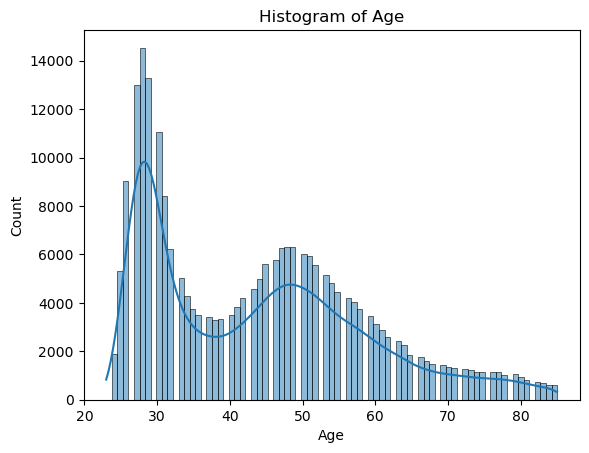

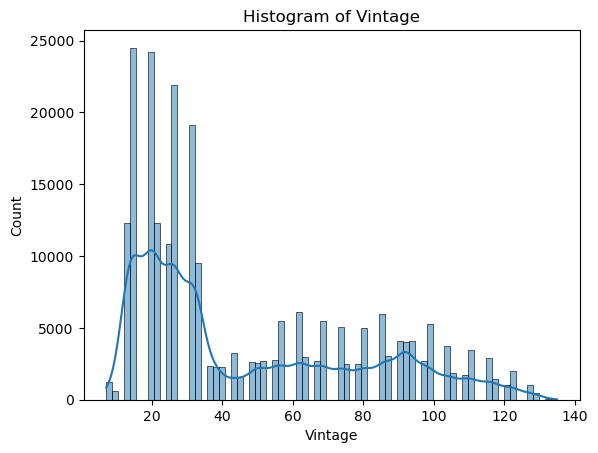

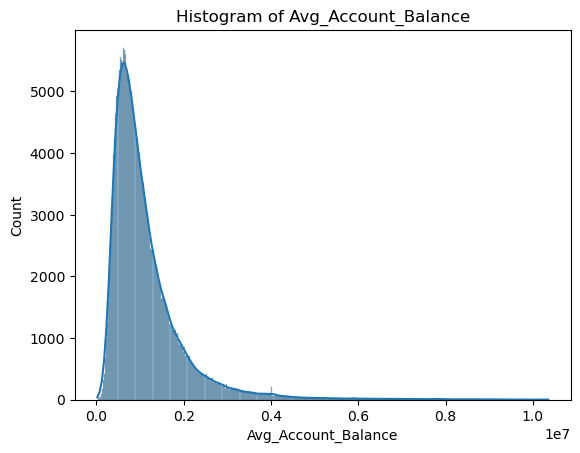

In [19]:
numerical_analysis(df, numerical)

#### Target Data Analysis

In [20]:
def target_analysis_with_numerical(dataframe, cat_types, target):
    
    pd.options.display.float_format = '{:,.2f}'.format
    
    for col in cat_types:
        if col != target:
            print("################# MEAN ####################")
            print(dataframe.groupby(target).agg({col: "mean"}), end="\n#####################################\n\n")

In [21]:
target = "Need_Credit_Card"

target_analysis_with_numerical(df, numerical, target)

################# MEAN ####################
                   Age
Need_Credit_Card      
0                41.95
1                49.99
#####################################

################# MEAN ####################
                  Vintage
Need_Credit_Card         
0                   41.91
1                   63.18
#####################################

################# MEAN ####################
                  Avg_Account_Balance
Need_Credit_Card                     
0                        1,103,018.02
1                        1,210,034.04
#####################################



In [22]:
df[target].value_counts(normalize=True) * 100

Need_Credit_Card
0   76.28
1   23.72
Name: proportion, dtype: float64

#### Replace Lables with Categories

In [23]:
def label_encoding(dataframe, columns):
     
    label_encoder = preprocessing.LabelEncoder() 
    
    for col in columns:
        dataframe[col] = label_encoder.fit_transform(dataframe[col]) 

In [24]:
label_encoding(df, ['Gender', 'Area_Code', 'Profession', 'Channel_Code', 'Has_Credit', 'Is_Active'])

In [25]:
df.head()

,Gender,Age,Area_Code,Profession,Channel_Code,Vintage,Has_Credit,Avg_Account_Balance,Is_Active,Need_Credit_Card
0,0,73,18,1,2,43,0,1045696,0,0
1,0,30,27,2,0,32,0,581988,0,0
2,0,56,18,3,2,26,0,1484315,1,0
3,1,34,20,2,0,19,0,470454,0,0
4,0,30,32,2,0,33,0,886787,0,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   Gender               245725 non-null  int32
 1   Age                  245725 non-null  int64
 2   Area_Code            245725 non-null  int32
 3   Profession           245725 non-null  int32
 4   Channel_Code         245725 non-null  int32
 5   Vintage              245725 non-null  int64
 6   Has_Credit           245725 non-null  int32
 7   Avg_Account_Balance  245725 non-null  int64
 8   Is_Active            245725 non-null  int32
 9   Need_Credit_Card     245725 non-null  int64
dtypes: int32(6), int64(4)
memory usage: 13.1 MB


#### Correlation Matrix

In [27]:
def correlation_matrix(dataframe,columns):
    fig = plt.gcf()
    fig.set_size_inches(10,8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig=sns.heatmap(dataframe[columns].corr(), annot=True, linewidths = 0.5, annot_kws={'size':12},linecolor='w',cmap='RdBu')
    plt.show(block=True)

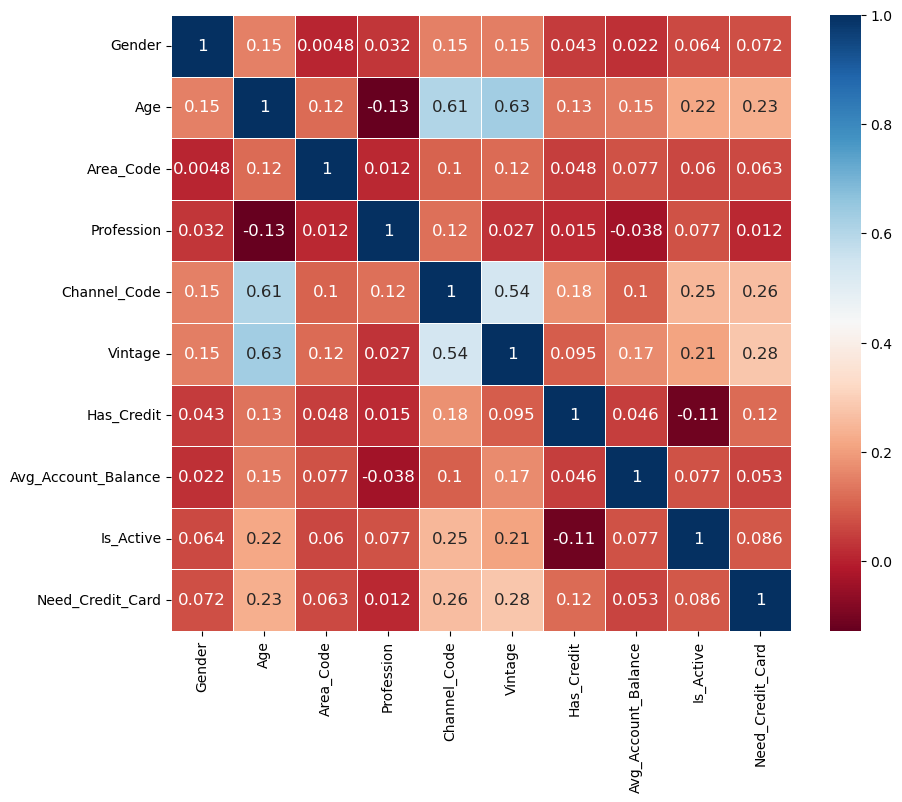

In [28]:
correlation_matrix(df, df.columns)

### Data Preprocessing & Feature Engineering

#### Outlier

In [29]:
def check_outlier(dataframe, columns):
    for col in columns:
        sns.boxplot(x=dataframe[col])
        plt.show()

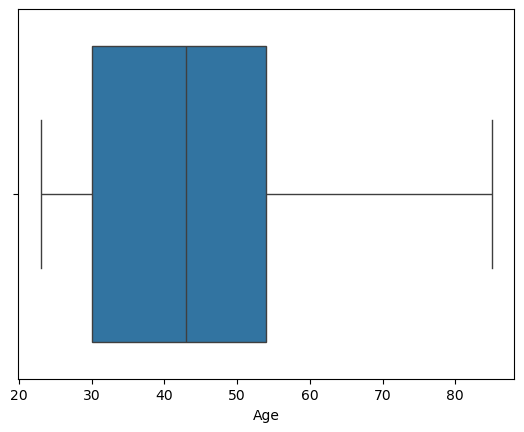

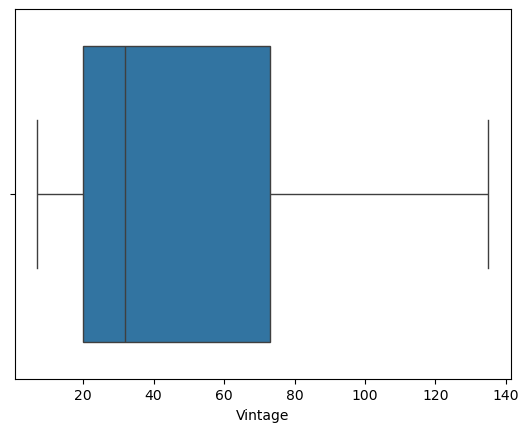

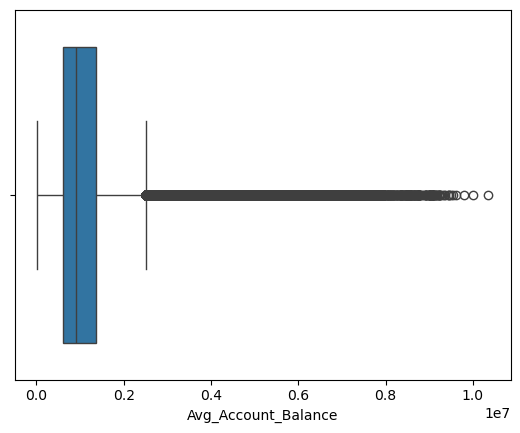

In [30]:
check_outlier(df, numerical)

In [31]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1= dataframe[col_name].quantile(q1)
    quartile3=dataframe[col_name].quantile(q3)
    interquartile_range = quartile3-quartile1
    up_limit = quartile3+1.5*interquartile_range
    low_limit = quartile1-1.5*interquartile_range
    return low_limit,up_limit

In [32]:
def replace_with_threshold(dataframe, variable):
    
    for var in variable:
        low_limit,up_limit = outlier_thresholds(dataframe, var)
        dataframe.loc[(dataframe[var]<=low_limit), var] = low_limit
        dataframe.loc[(dataframe[var]>=up_limit), var] = up_limit

In [33]:
replace_with_threshold(df, numerical)

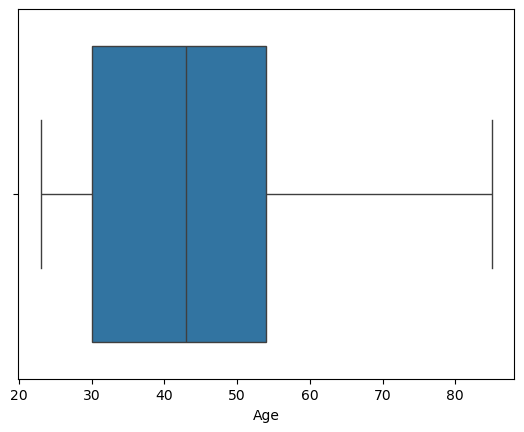

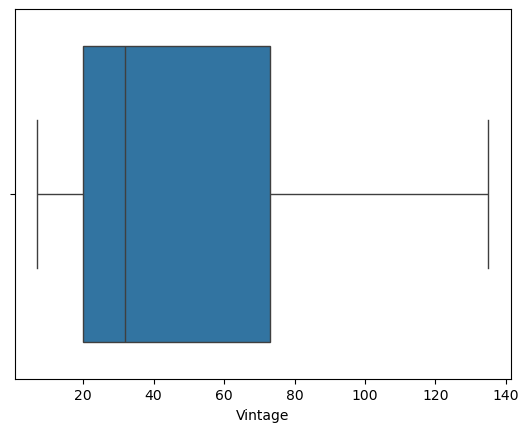

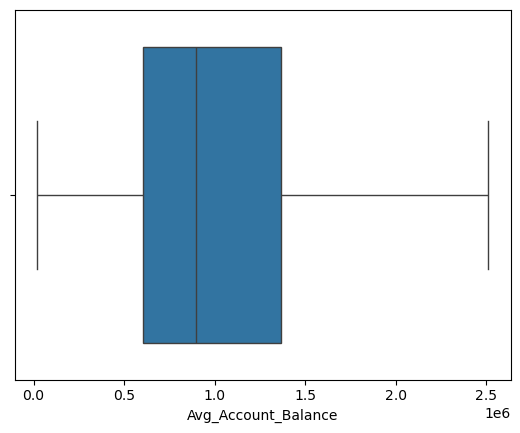

In [34]:
check_outlier(df, numerical)

#### Data Split into Train and Test

In [35]:
y = df[target]
X = df.drop(target, axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

#### Normalize Data

In [36]:
def normalize(dataframe):
    for col in dataframe.columns:
        max_value = dataframe[col].max()
        min_value = dataframe[col].min()
        dataframe[col] = (dataframe[col] - min_value) / (max_value - min_value)

In [37]:
normalize(X_train)
normalize(X_test)

In [38]:
X_train.head()

,Gender,Age,Area_Code,Profession,Channel_Code,Vintage,Has_Credit,Avg_Account_Balance,Is_Active
118741,0.00,0.13,0.12,0.67,0.00,0.14,0.00,0.64,0.00
68819,0.00,0.65,0.79,0.33,0.00,0.20,0.00,0.18,0.00
19807,1.00,0.32,0.97,0.67,0.33,0.11,0.00,0.30,1.00
225666,0.00,0.08,1.00,0.67,0.00,0.06,0.00,0.57,1.00
118454,1.00,0.39,0.12,1.00,0.67,0.66,1.00,0.35,1.00


In [39]:
X_test.head()

,Gender,Age,Area_Code,Profession,Channel_Code,Vintage,Has_Credit,Avg_Account_Balance,Is_Active
139356,0.00,0.05,0.53,1.00,0.00,0.05,0.00,0.14,1.00
224457,1.00,0.07,0.94,0.67,0.00,0.09,0.00,0.48,1.00
174299,1.00,0.33,0.97,1.00,0.33,0.52,0.00,0.18,0.00
215090,1.00,0.08,0.21,0.67,0.00,0.20,1.00,0.46,0.00
39704,0.00,0.46,0.53,1.00,0.67,0.95,0.00,1.00,1.00


### The Model

In [40]:
# !pip install xgboost

In [41]:
from xgboost import XGBClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

#### XGBoosting Algorithm

In [ ]:
param = {"n_estimators":sp_randint(40,100), 
         "colsample_bytree":np.array([0.5,0.6,0.7,0.8,0.9,1]),
         "subsample":np.array([0.5,0.6,0.7,0.8,0.9,1]),
         "reg_lambda":np.array([1e-5,1e-4,1e-3,1e-2,0.1,1,10,100]),
         "reg_alpha":np.array([1e-5,1e-4,1e-3,1e-2,0.1,1,10,100]),
         "min_child_samples": sp_randint(25,65),
         "max_depth": sp_randint(1,20)}

clf_xgb_model = XGBClassifier(boosting_type = "gbdt", 
                              n_jobs =-1, 
                              random_state = 0, 
                              verbosity =0, 
                              scale_pos_weight = 3.2158)

xgb_random_cv = RandomizedSearchCV(clf_xgb_model, param_distributions = param,
                                         n_iter=20, cv=20, scoring='roc_auc',random_state=42,
                                         verbose=1)

xgb_random_cv.fit(X_train, y_train)

Fitting 20 folds for each of 20 candidates, totalling 400 fits


In [ ]:
print('mean CV test scores', xgb_random_cv.cv_results_['mean_test_score'])

In [ ]:
print('mean CV test scores', statistics.mean(xgb_random_cv.cv_results_['mean_test_score']))

In [ ]:
print("The Best Parameters: ", xgb_random_cv.best_estimator_)

#### Final Model XGBoosting

In [ ]:
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='gbdt', 
                          colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
                          gamma=0, gpu_id=-1, importance_type='gain', learning_rate=0.01,
                          max_delta_step=0, max_depth=7, min_child_samples=52,
                          min_child_weight=1, n_estimators=46, n_jobs=-1, num_parallel_tree=1, 
                          random_state=0, reg_alpha=1e-05, reg_lambda=100.0, scale_pos_weight=3.2158,
                          subsample=0.8, tree_method='exact', validate_parameters=1, verbosity=0)


In [ ]:
xgb_model.fit(X_train, y_train)

In [ ]:
y_log = xgb_model.predict(X_test)

In [ ]:
y_pred = np.where(y_log > 0.5, 1, 0)

In [ ]:
y_pred

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')